# Getting Started with DoWhy in Python

Source: https://www.datacamp.com/tutorial/intro-to-causal-ai-using-the-dowhy-library-in-python

Microsoft’s DoWhy library, developed in collaboration with Amazon Web Services as part of the PyWhy ecosystem, is quickly becoming the industry standard for causal analysis in the Python universe. We can use DoWhy to simulate a data set according to our causal model above, illustrating some of the fundamental steps in the causal inference pipeline. First, we need to install DoWhy in our environment.

In [1]:
#!pip install numpy pandas -q
#!pip install git+https://github.com/microsoft/dowhy.git -q
#!pip install scikit-learn==1.1.3 -q

In [2]:
import numpy as np
import pandas as pd
import dowhy

/home/randi_eka/anaconda3/envs/causal-ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now, let’s create a dataset ourselves. The major benefit of working with simulated data when studying causal AI is that we have full control over the data generating process and knowledge of the “ground truth,” which wouldn’t be the case with real-world data.

We set the true causal effect equal to one (beta=1), specify two common causes, and create ten thousand samples according to simple linear relationships between the variables in the model.

The variable we are examining in our treatment is set to binary, meaning it can be either zero or one.

Before, we established a fixed point of origin for our random number generation - using np.random.seed(1) - to enable a precise reproduction of our dataset.

In [3]:
from dowhy import CausalModel
import dowhy.datasets

# Set seed to enable exact replication
np.random.seed(1)

# Simulate sample data
data = dowhy.datasets.linear_dataset(
    beta = 1,
    num_common_causes = 2,
    num_discrete_common_causes = 1,
    num_instruments = 1,
    num_samples = 10000,
    treatment_is_binary=True
)

df = data['df']

In [4]:
df.head()

,Z0,W0,W1,v0,y
0,0.0,-0.694128,0,True,0.510989
1,1.0,0.699452,0,True,1.495845
2,0.0,1.578856,0,False,1.112997
3,0.0,0.153083,1,True,1.849269
4,0.0,1.296152,0,True,1.931800


DoWhy assigns the following labels:

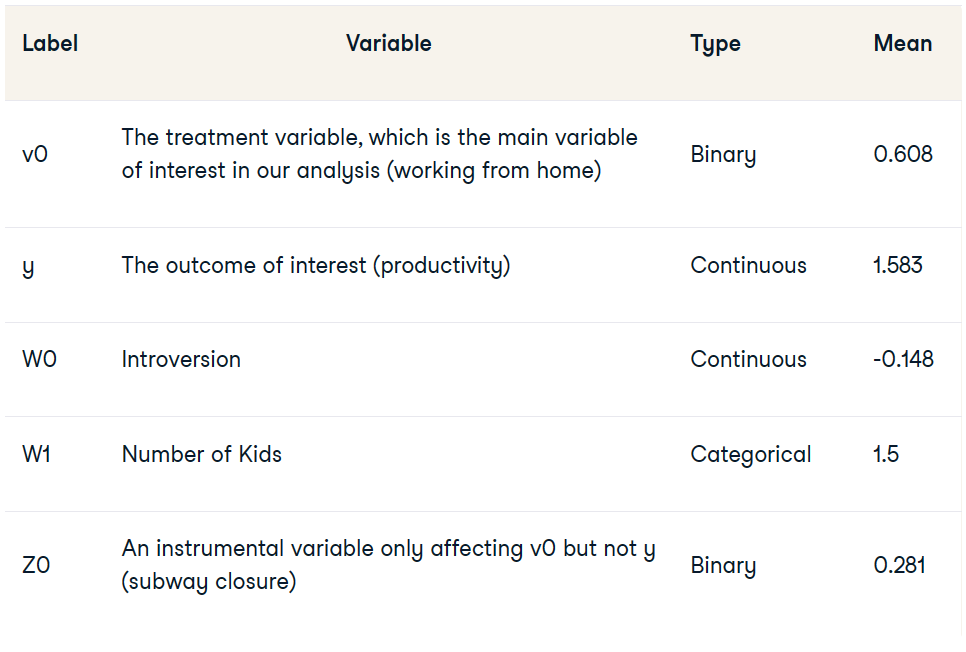

Here, we have implicitly defined a causal graph by setting the type of treatment and the number of common causes. DoWhy stores graph objects in the DOT language, which gives us a convenient way of specifying our own directed causal graph (digraph) once we’re working with real-world data.

```
digraph {v0->y;W0-> v0; W1-> v0;Z0-> v0;W0-> y; W1-> y;}
```

Finally, we combine all of this information into one single causal model.

In [5]:
# Create a causal model from the data and given graph.
model = CausalModel(
    data = df,
    treatment = data['treatment_name'],
    outcome = data['outcome_name'],
    graph = data['gml_graph']
)

## Unlocking the Power of Causal AI

Before we carry out causal analysis, let's benchmark it with what a naive approach based on a simple linear prediction algorithm would tell us.

In [6]:
# Run a linear regression of column y on v0 in df
import statsmodels.api as sm

X = df['v0'].astype(float)
y = df['y'].astype(float)

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()

# Display a more parsimonious results summary
print(ols.summary().tables[1])


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7966      0.017     47.194      0.000       0.764       0.830
v0             1.2947      0.022     59.804      0.000       1.252       1.337


The slope coefficient in a bivariate regression is equal to 1.298. However, we know that the true causal effect is actually equal to one, as we have generated the data in this manner.

This implies that the two common causes, introversion and having children, which both influence productivity and the likelihood of working from home, lead to an overestimation of almost 30% in this case.

Fortunately, as long as we have data on these variables, we can easily address this bias by including the common causes in a multivariate analysis.

In the causal AI literature, this is known as the backdoor criterion. We want to control for all variables in the causal graph that point into the treatment variable. They “enter through the backdoor” and thus potentially create a spurious correlation between the treatment and outcome that is not causal. In our example, this applies to introversion and the number of kids.

WFH <— Introversion —> Productivity

WFH <— Kids —> Productivity

DoWhy offers a range of algorithms that can be used to determine if a desired causal effect can be identified when given a particular causal model.



In [7]:
# Check whether causal effect is identified and return target estimands
identified_estimand = model.identify_effect()

In [18]:
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W1,W0])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                      -1⎤
 ⎢  d      ⎛  d        ⎞  ⎥
E⎢─────(y)⋅⎜─────([v₀])⎟  ⎥
 ⎣d[Z₀]    ⎝d[Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### From Copilot
The image you provided shows mathematical expressions and assumptions related to statistical estimands. In simple terms, an estimand is a way to estimate the effect of a treatment or variable on an outcome, considering various assumptions and conditions. For example, if you want to understand the impact of studying hours (treatment) on exam scores (outcome), these estimands can help quantify that relationship while considering other factors that might influence the results.

Here are the three types of estimands shown in your image:

Backdoor Estimand: This estimand uses the concept of ‘unconfoundedness’. It assumes that given certain observed variables, the treatment assignment is independent of potential outcomes. For example, if you want to measure the effect of studying hours on exam scores, you would need to consider other factors like student’s intelligence, which could also affect the scores.

Instrumental Variable (IV) Estimand: This estimand uses an ‘instrumental variable’, a variable that affects the treatment but has no direct effect on the outcome. For example, the distance from home to library could be an instrumental variable when studying the effect of studying hours on exam scores. The distance might affect how long a student studies, but it doesn’t directly affect the exam scores.

Frontdoor Estimand: This estimand isn’t applicable in the context of your image, but generally, it involves a variable that mediates the effect of the treatment on the outcome.

#### Continue the interpretation
Unsurprisingly, in our simple causal model for the effect of working from home, causal identification is possible.

Next, we can focus on estimation, which is the process of quantifying the target effect using the available data.

DoWhy offers a number of algorithms to choose from, including regression, matching, stratification, and weighting estimators. Since the underlying data we simulated was based on linear relationships, a simple regression would suffice. If you need a refresher, DataCamp’s Intro to Regression with statsmodels in Python course can help.

However, to make our analysis more general, we will use inverse probability weighting, which is also able to handle nonlinear data.

In [8]:
# Estimate the causal effect using inverse probability weighting
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting")

In [15]:
estimate.value

DoWhy returns a causal effect estimate equal to 1.001. Of course, the actual numbers are not very meaningful in this simulated context. However, what’s important is that we are very close to the ground truth of one. Compared to the regression we ran before, the bias has been reduced by a staggering 99.6%.

## Stress Testing Your Results
That’s all very impressive, but we shouldn’t stop there.

The “no causes in, no causes out” principle tells us that any causal analysis can only be as good as the assumptions we bring to the table.

For example, how can we be sure that it’s only introversion and kids which affect WFH, as our simple causal model stipulates?

To gain more confidence in our assumptions, DoWhy provides us with a whole suite of refutation tests that allow us to stress test our analysis, including but not limited to testing with subsamples or placebo treatments.

/home/randi_eka/anaconda3/envs/causal-ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/randi_eka/anaconda3/envs/causal-ml/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/randi_eka/anaconda3/envs/causal-ml/lib/python3.10/site-packages/dowhy/causal_refuters/add_unobserved_common_cause.py:321: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

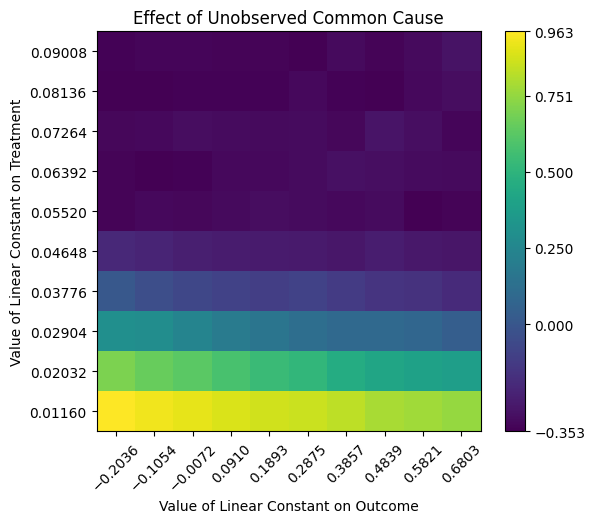

In [21]:
# Check sensitivity of obtained estimate to unobserved confounders
refute_results = model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause")

#### From Copilot

In simpler terms, when testing for a cause-and-effect relationship between two things (like introversion and having kids), there might be another hidden factor that influences both, leading to incorrect conclusions.

For example, imagine studying the relationship between ice cream sales and drowning incidents—they both increase in summer but are influenced by the hidden variable “temperature.” In this case, adding an unobserved common cause can drastically change the estimated effect, making it unreliable.

The graph in the article illustrates this concept. It shows that when an unobserved common cause is added, the estimated causal effect can range from -0.222 to 1.003. This range is so wide that it could potentially double the estimated effect1. This means that the model’s estimate of the effect of one variable on another can be significantly off if there are hidden factors not accounted for in the model.

In real-world scenarios, this could mean that a policy or strategy based on such a model might not have the intended effect, or could even have the opposite effect. Therefore, it’s crucial to consider all possible factors and gather as much data as possible when building models to inform decisions.

#### Continue the Interpretation
Let’s see what happens if we add another common cause in addition to introversion and kids.

This time, we don't have data on this variable, so it will remain unobservable to us. How reliable are our estimates? Unfortunately, the answer is not very reassuring.

The graph in Figure 2 illustrates the substantial influence that unobserved common causes can have on the estimated causal effect, ranging from -0.222 to 1.003. This range is so wide that it could potentially double the estimated effect.

That’s not very surprising, though. Alternative causal mechanisms involving unobserved variables that we cannot account for in the analysis will always pose a problem in causal studies.

Fortunately, there is an alternative way to achieve identification in this context, and DoWhy is smart enough to figure it out for us.

## Finding Alternative Causal Strategies
Even though introverted employees and those with kids might work from home more frequently, there may be other determinants of WFH that are not related to productivity.

Let’s say we had a major public transport disruption, and one of the subway lines in our city had to be closed for three months. As a result, employees who lived in districts close to the line were more likely to work from home, even if they would have otherwise preferred to come to the office.

We can illustrate this augmented causal model as follows.

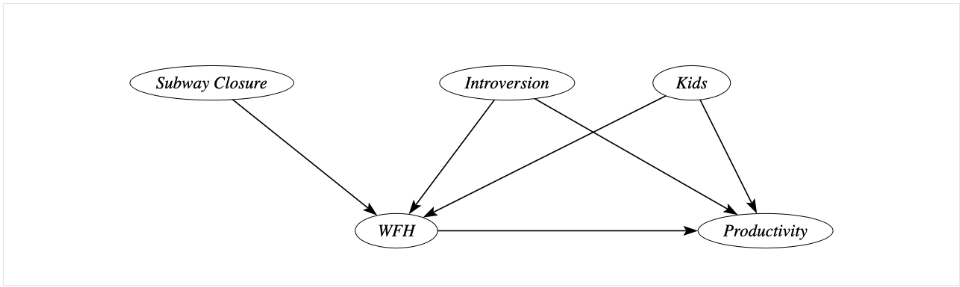

In this case, the subway closure acts as a so-called instrumental variable.

Intuitively, the closure acts as a shock to people’s commuting schedules, creating a form of natural experiment.

For three months, those living close to the disrupted line will work from home more often, but this has no other relation to their productivity. You may have noticed that we have already included such an instrumental variable, Z0, in the creation of the simulated data set above by setting the option num_instruments=1. DoWhy’s identify_effect() function is then able to automatically find suitable instrumental variables for us in the causal graph.

In [22]:
iv_estimate = model.estimate_effect(identified_estimand,
                                    method_name="iv.instrumental_variable")

In [23]:
print(iv_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                      -1⎤
 ⎢  d      ⎛  d        ⎞  ⎥
E⎢─────(y)⋅⎜─────([v₀])⎟  ⎥
 ⎣d[Z₀]    ⎝d[Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡ d    ⎤  -1⎡ d     ⎤
E⎢───(y)⎥⋅E  ⎢───(v₀)⎥
 ⎣dZ₀   ⎦    ⎣dZ₀    ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and ['y']
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome ['y'] is affected in the same way by common caus

After estimating, we find that the causal effect is 0.920. This is slightly less accurate than the backdoor strategy but still much more accurate than the naive prediction.

Instrumental variable estimation is advantageous because it does not rely on assumptions about the number of unobserved common causes of WFH and productivity.

Thus, although our estimates may be less precise, they are more robust due to the weaker assumptions. This is a common trade-off in causal analysis.

## What’s Next?
DoWhy is an excellent place to get started with causal AI. It’s a powerful end-to-end library that provides a versatile causal inference pipeline, which guides users through the essential steps.

Once you have grasped the fundamental workflow, you can progress to more advanced topics such as causal discovery and boost your analysis with additional libraries such as DoubleML, or daggity, ggdag, and pcalg in R. Once you're comfortable with the basics, you might want to explore more advanced topics in causal inference. DataCamp's Advanced Causal Inference with R course is a great next step.

Causal inference offers a fresh outlook on data analysis. Most approaches depend on an understanding of the causal graph or other causal assumptions. The trick is to select the techniques and assumptions that are suitable for your particular situation. This requires external knowledge and domain expertise.

Therefore, it’s a good idea to consult with your marketing experts or HR specialists to get their opinions on a particular issue and see if they can help you come up with a suitable model.

Causal knowledge is crucial in many business contexts. We need to understand, for example, whether our new product launch is successful or how effective our advertising strategy is.

Obtaining causal answers from data might be a harder task than training a simple prediction algorithm, but it’s well worth the effort. And libraries such as DoWhy provide you with a great set of tools that will help you to find the solutions that best fit your needs.

If you've found this tutorial enlightening and are eager to apply causal AI techniques in your own projects, there's no better time to deepen your understanding. In the comprehensive course on Machine Learning for Business, you'll learn not just about predictive models but also about causal models that can help you make better business decisions.##